# Pylops - Least squares image-domain migration - marmousi model

### Author: M.Ravasi

In this notebook we show how to use the ``NonStationaryConvolve2D`` operator to perform image-domain least-squares migration

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import scipy as sp
from scipy.signal import filtfilt
from scipy.sparse.linalg import lsqr
from numba import jit

from pylops import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from pylops.avo.poststack              import PoststackLinearModelling, PoststackInversion

from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import *

## Model and data creation

Lets' create a model and geometry

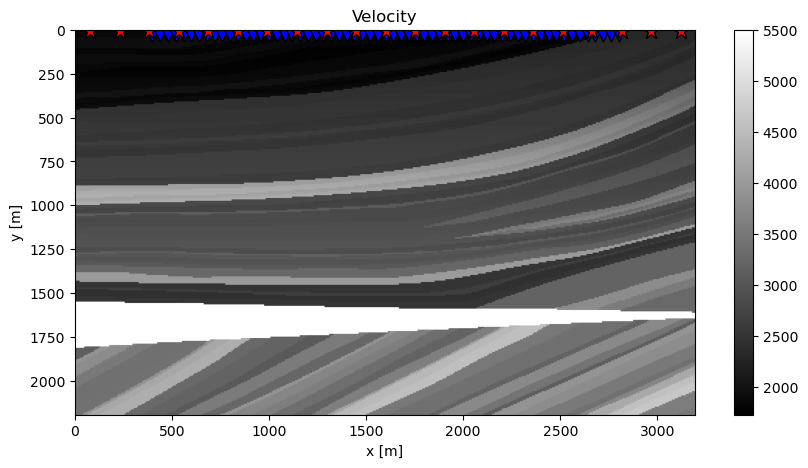

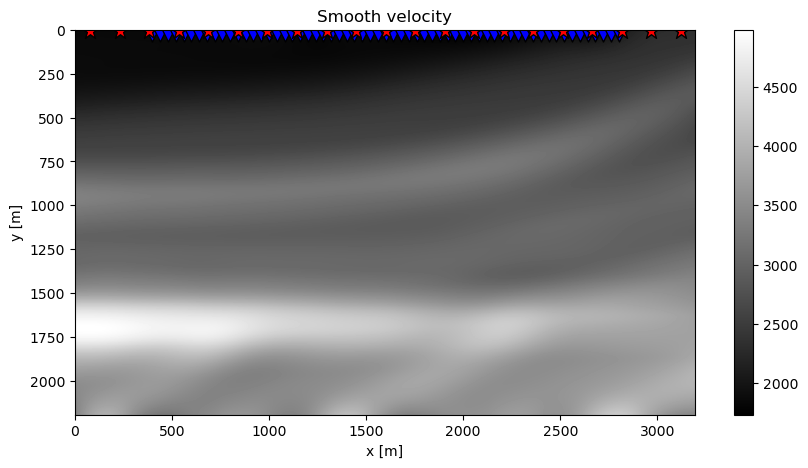

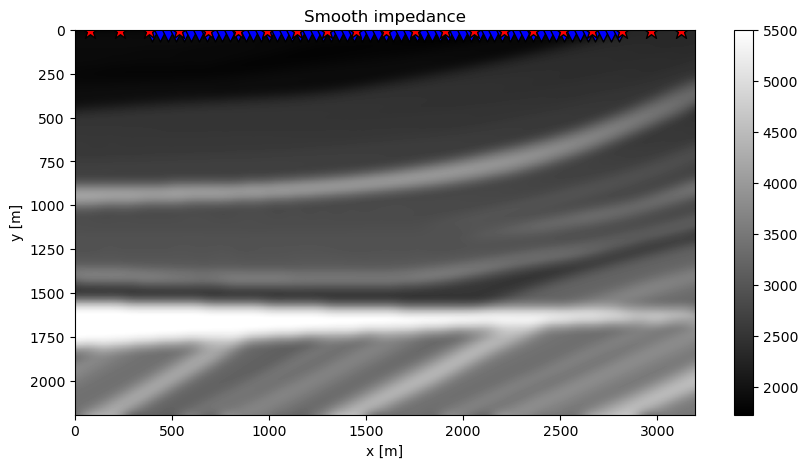

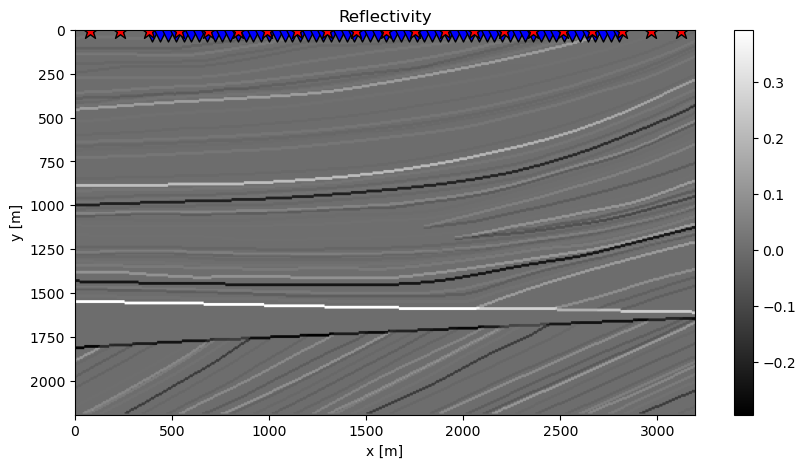

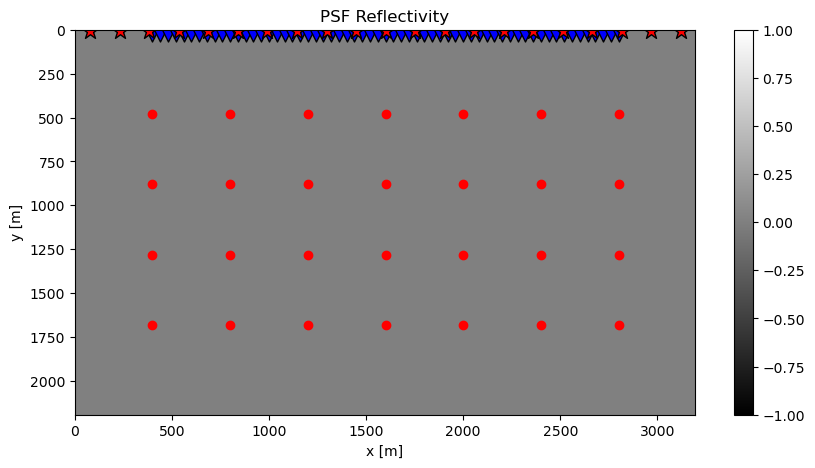

In [2]:
#Velocity
inputfile='../../pylops/testdata/avo/poststack_model.npz'

model = np.load(inputfile)
x, z, vel_true = model['x'] - model['x'][0], model['z'] - model['z'][0], 1000*model['model'].T
x, z, vel_true = x[::2], z[::2], vel_true[::2, ::2]
nx, nz = len(x), len(z)
dx, dz = x[1]-x[0], z[1]-z[0]

# Impedance
rho = 1.
ip_true = rho * vel_true

# Reflectivity
Dop = FirstDerivative(dims=(nx, nz), axis=1)
refl = Dop * np.log(ip_true)

# PSF Model
psfrefl = np.zeros((nx, nz))
psfin = (50, 60)
psfend = (-49, -49)
psfj = (50, 50)
psfsize = (31, 31)
psfrefl[psfin[0]:psfend[0]:psfj[0], psfin[1]:psfend[-1]:psfj[-1]] = 1

# PSF grid
psfx = np.arange(psfin[0], nx+psfend[0], psfj[0])
psfz = np.arange(psfin[1], nz+psfend[1], psfj[1])
Psfx, Psfz = np.meshgrid(psfx, psfz, indexing='ij')

# Smooth velocity
nsmooth = 30
vel_sm = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_true, axis=0)
vel_sm = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, vel_sm, axis=1)

# Smooth impedance
nsmooth = 10
ip_sm = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, ip_true, axis=0)
ip_sm = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, ip_sm, axis=1)

# Receivers
nr = 61
rx = np.linspace(dx*50, (nx-50)*dx, nr)
rz = 20*np.ones(nr)
recs = np.vstack((rx, rz))
dr = recs[0,1]-recs[0,0]

# Sources
ns = 21
sx = np.linspace(dx*10, (nx-10)*dx, ns)
sz = 10*np.ones(ns)
sources = np.vstack((sx, sz))
ds = sources[0,1]-sources[0,0]

plt.figure(figsize=(10,5))
im = plt.imshow(vel_true.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Velocity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(vel_sm.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0], recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Smooth velocity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(ip_sm.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0], recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Smooth impedance')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(refl.T, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0],  recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('Reflectivity')
plt.ylim(z[-1], z[0])

plt.figure(figsize=(10,5))
im = plt.imshow(psfrefl.T, cmap='gray', vmin=-1, vmax=1, extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(recs[0], recs[1], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(sources[0], sources[1], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(Psfx.ravel()*dx, Psfz.ravel()*dz, c='r')
plt.colorbar(im)
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]')
plt.title('PSF Reflectivity')
plt.xlim(x[0], x[-1]);

### Dataset creation and migration

In [3]:
nt = 601
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

kop = Kirchhoff(z, x, t, sources, recs, vel_sm, wav, wavc, mode='eikonal', 
                dynamic=False, wavfilter=True, engine='numba')
kopdyn = Kirchhoff(z, x, t, sources, recs, vel_sm, wav, wavc, mode='eikonal', 
                   dynamic=True, wavfilter=True, aperture=2, angleaperture=50, engine='numba')

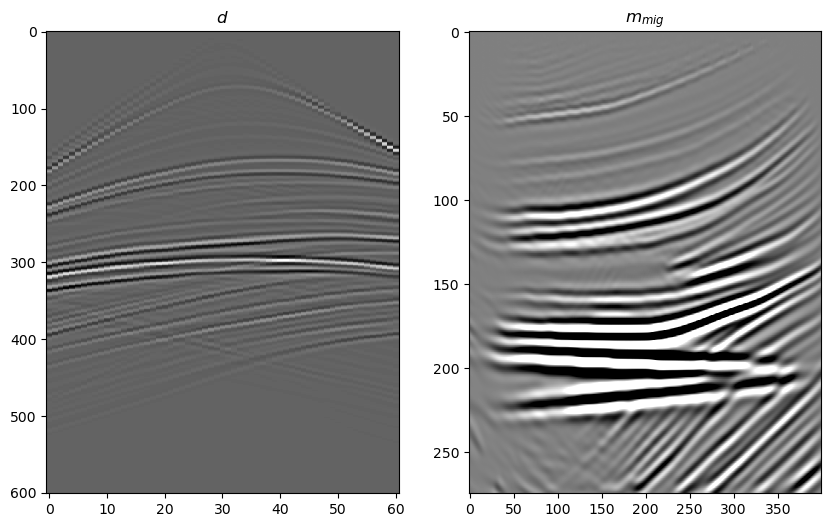

In [4]:
d = kop * refl.ravel()
d = d.reshape(ns, nr, nt)

mmig = kopdyn.H * d.ravel()
mmig = mmig.reshape(nx, nz)

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].imshow(d[ns//2, :, :].T, cmap='gray', interpolation='none')
axs[0].set_title(r'$d$')
axs[0].axis('tight')
axs[1].imshow(mmig.T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[1].set_title(r'$m_{mig}$')
axs[1].axis('tight');

### PSF creation and migration

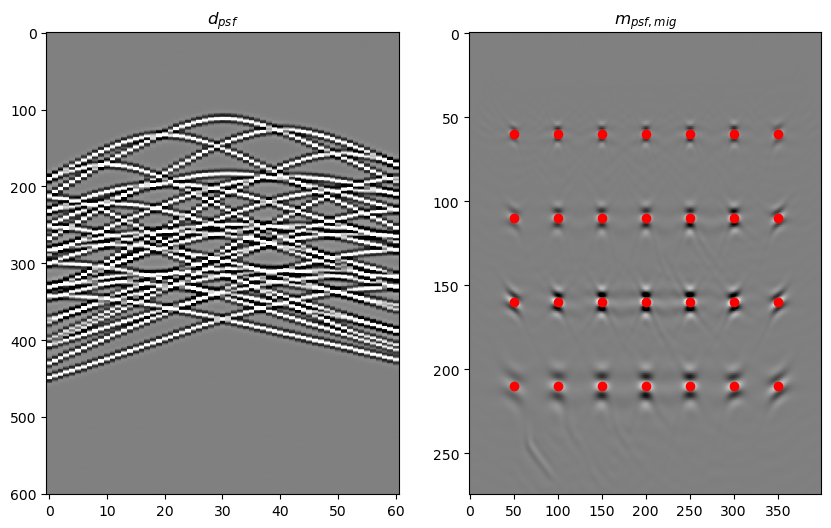

In [5]:
dpsf = kop * psfrefl.ravel()
dpsf = dpsf.reshape(ns, nr, nt)

mmigpsf = kopdyn.H * dpsf.ravel()
mmigpsf = mmigpsf.reshape(nx, nz)

fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs[0].imshow(dpsf[ns//2, :, :].T, cmap='gray', vmin=-1e2, vmax=1e2, interpolation='none')
axs[0].set_title(r'$d_{psf}$')
axs[0].axis('tight')
axs[1].imshow(mmigpsf.T, cmap='gray', vmin=-4, vmax=4)
axs[1].scatter(Psfx.ravel(), Psfz.ravel(), c='r')
axs[1].set_title(r'$m_{psf,mig}$')
axs[1].axis('tight');

## Image domain LSM

First, we extract the different PSFs

In [6]:
psfs = np.zeros((len(psfx), len(psfz), *psfsize))

for ipx, px in enumerate(psfx):
    for ipz, pz in enumerate(psfz):
        psfs[ipx, ipz] = mmigpsf[int(px-psfsize[0]//2):int(px+psfsize[0]//2+1), 
                                 int(pz-psfsize[1]//2):int(pz+psfsize[1]//2+1)] 

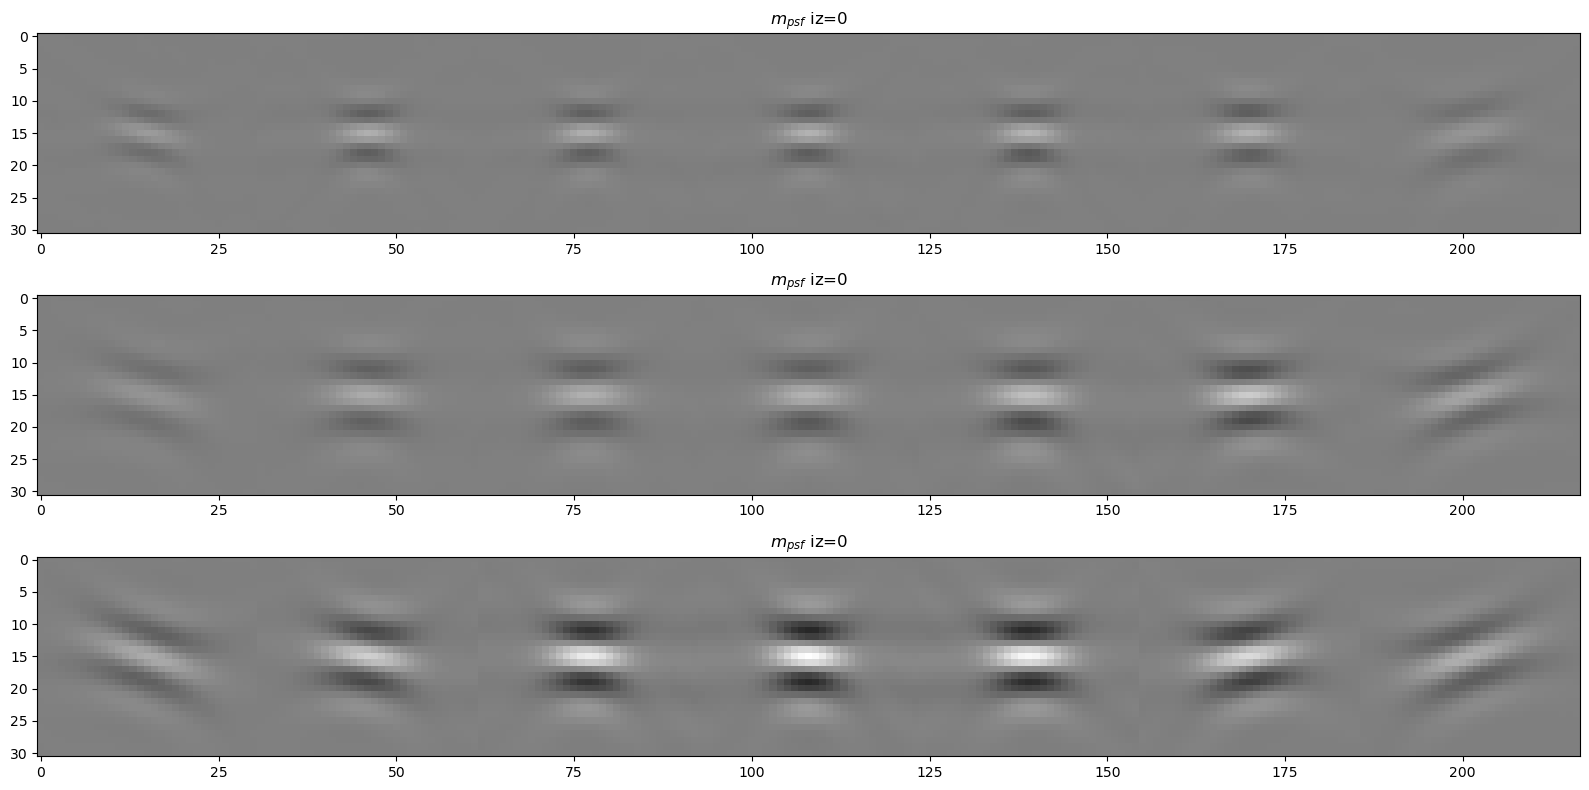

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(16, 8))
axs[0].imshow(psfs[:, 0].reshape(len(psfx)*psfsize[0], psfsize[1]).T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[0].set_title(r'$m_{psf}$ iz=0')
axs[0].axis('tight')
axs[1].imshow(psfs[:, 1].reshape(len(psfx)*psfsize[0], psfsize[1]).T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[1].set_title(r'$m_{psf}$ iz=0')
axs[1].axis('tight')
axs[2].imshow(psfs[:, 2].reshape(len(psfx)*psfsize[0], psfsize[1]).T, cmap='gray', vmin=-1e1, vmax=1e1)
axs[2].set_title(r'$m_{psf}$ iz=0')
axs[2].axis('tight')
plt.tight_layout()

Now we create two operators, one on CPU and the other on GPU and compare them

In [8]:
Cop = NonStationaryConvolve2D(dims=(nx, nz), hs=psfs, ihx=psfx, ihz=psfz, engine="numba")
Cop_cuda = NonStationaryConvolve2D(dims=(nx, nz), hs=cp.asarray(psfs), ihx=psfx, ihz=psfz, engine="cuda")

mmigforw = Cop * refl
mmigforw_cuda = Cop_cuda * cp.asarray(refl)

mmigadj = Cop.H * mmigforw
mmigadj_cuda = Cop_cuda.H * mmigforw_cuda
np.allclose(mmigforw, mmigforw_cuda, atol=1e-5), np.allclose(mmigadj, mmigadj_cuda, atol=1e-5)

(array(False), array(False))

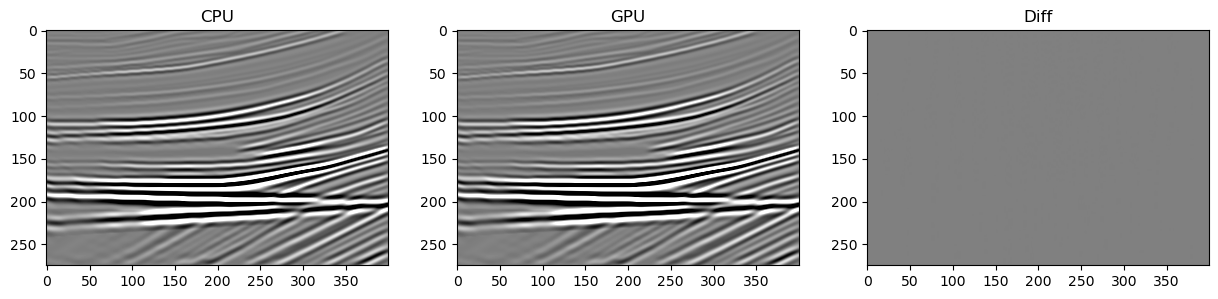

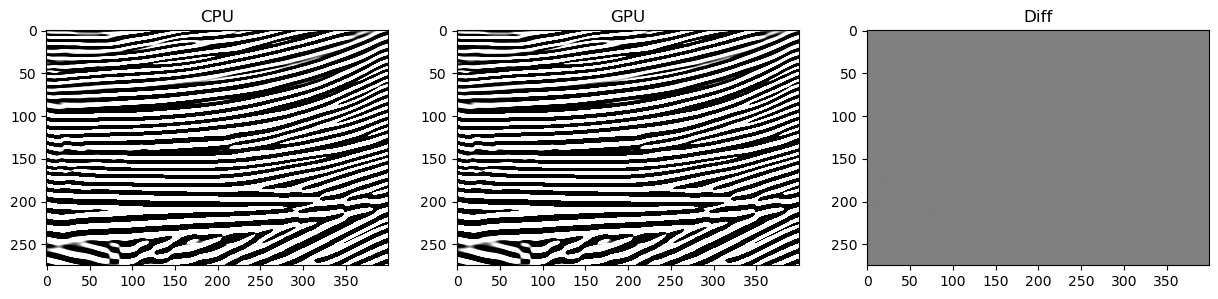

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))
axs[0].imshow(mmigforw.T, vmin=-1e1, vmax=1e1, cmap='gray')
axs[0].set_title('CPU')
axs[1].imshow(cp.asnumpy(mmigforw_cuda).T, vmin=-1e1, vmax=1e1, cmap='gray')
axs[1].set_title('GPU')
axs[2].imshow(mmigforw.T-cp.asnumpy(mmigforw_cuda).T, vmin=-1e10, vmax=1e10, cmap='gray')
axs[2].set_title('Diff');

fig, axs = plt.subplots(1, 3, figsize=(15, 8))
axs[0].imshow(mmigadj.T, vmin=-1e1, vmax=1e1, cmap='gray')
axs[0].set_title('CPU')
axs[1].imshow(cp.asnumpy(mmigadj_cuda).T, vmin=-1e1, vmax=1e1, cmap='gray')
axs[1].set_title('GPU')
axs[2].imshow(mmigadj.T-cp.asnumpy(mmigadj_cuda).T, vmin=-1e10, vmax=1e10, cmap='gray')
axs[2].set_title('Diff');

In [10]:
dottest(Cop, verb=True, raiseerror=False), dottest(Cop_cuda, verb=True, backend="cupy", raiseerror=False);

Dot test failed, v^H(Opu)=-8950.693628515912 - u^H(Op^Hv)=-8948.249019323464
Dot test passed, v^H(Opu)=1636.7251139333694 - u^H(Op^Hv)=1636.725113933382


In [11]:
# Timings
x = mmigpsf
xcp = cp.asarray(mmigpsf)

%timeit Cop * x
%timeit Cop_cuda * xcp

%timeit Cop.H * x
%timeit Cop_cuda.H * xcp

45 ms ± 2.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.34 ms ± 65.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
43.7 ms ± 1.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
7.11 ms ± 147 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Inversion

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 110000 rows and 110000 cols
eps = 4.000000e+01	tol = 1.000000e-10	niter = 200
alpha = 4.376604e-06	thresh = 8.753209e-05
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1       0.0000e+00         1.037e+06   1.063e+06   4.710e+00
     2       0.0000e+00         6.121e+05   6.466e+05   1.530e+00
     3       0.0000e+00         3.937e+05   4.357e+05   1.214e+00
     4       0.0000e+00         2.684e+05   3.166e+05   1.017e+00
     5       0.0000e+00         1.921e+05   2.454e+05   8.711e-01
     6       0.0000e+00         1.436e+05   2.013e+05   7.542e-01
     7       0.0000e+00         1.114e+05   1.728e+05   6.600e-01
     8       0.0000e+00         8.900e+04   1.536e+05   5.847e-01
     9       0.0000e+00         7.279e+04   1.400e+05   5.244e-01
    10      

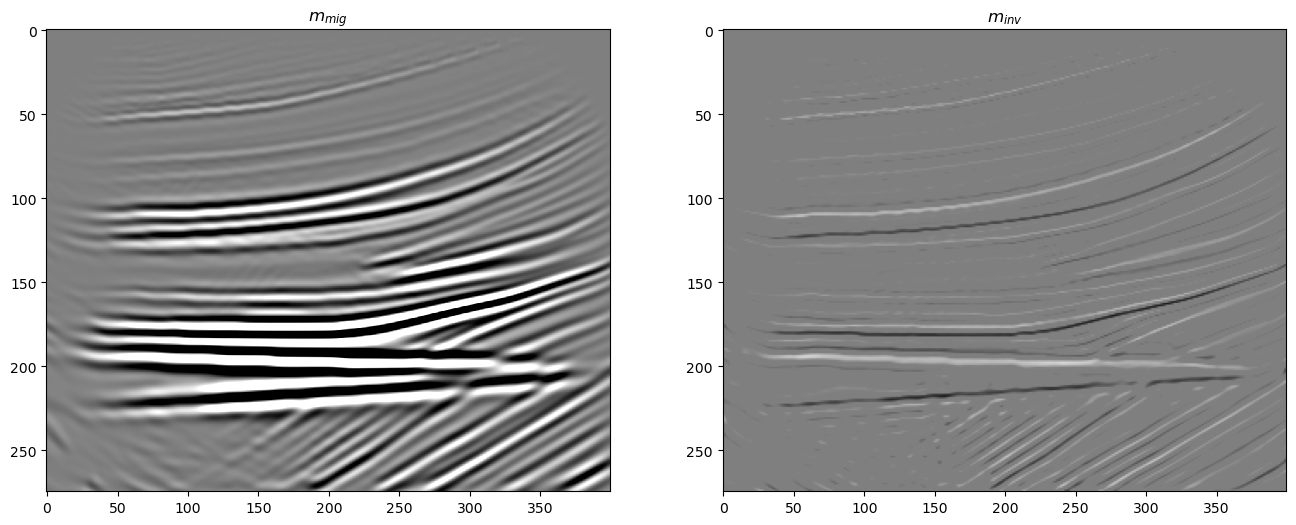

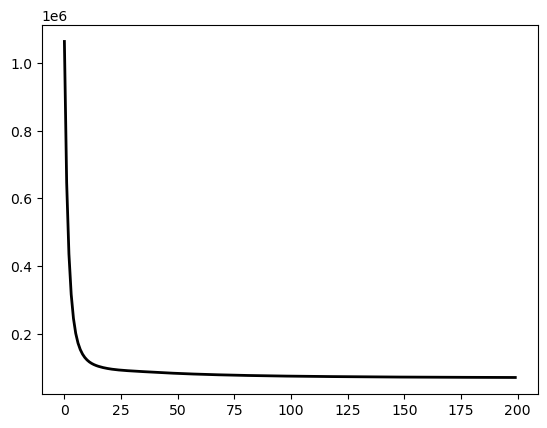

In [12]:
reflinv, _, resnorm = fista(Cop_cuda, cp.asarray(mmig).ravel(), eps=4e1, niter=200, 
                            eigsdict=dict(niter=5, tol=1e-2), show=True)
reflinv = cp.asnumpy(reflinv).reshape(nx, nz)

fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].imshow(mmig.T, cmap='gray', vmin=-10, vmax=10)
axs[0].set_title(r'$m_{mig}$')
axs[0].axis('tight')
axs[1].imshow(reflinv.T, cmap='gray', vmin=-0.5, vmax=0.5)
axs[1].set_title(r'$m_{inv}$')
axs[1].axis('tight')

plt.figure()
plt.plot(resnorm, 'k', lw=2);

## Scalability test

Let's finally test scalability on a larger model


In [13]:
def time_numba(Op, x, n=10, unit='s'):
    timing = np.empty(n)
    for i in range(timing.size):
        tic = perf_counter()
        y = Op @ x
        toc = perf_counter()
        timing[i] = toc - tic
    if unit == 'ms':
        timing *= 1e3  # convert to ms
    print(f"Elapsed time: {timing.mean():.2f} ± {timing.std():.2f} {unit}")      
    return timing.mean()

In [14]:
from time import perf_counter
from numba import jit, cuda

def time_cuda(Op, x, n=10, unit='s'):
    cuda.synchronize()
    timing = np.empty(n)
    for i in range(timing.size):
        tic = perf_counter()
        y = Op @ x
        cuda.synchronize()
        toc = perf_counter()
        timing[i] = toc - tic
    if unit == 'ms':
        timing *= 1e3  # convert to ms
    print(f"Elapsed time: {timing.mean():.2f} ± {timing.std():.2f} {unit}")      
    return timing.mean()

In [15]:
nmodels = [500, 1000, 1500, 2000, 3000, 4000]

tsnumba = []
tscuda = []
for nmodel in nmodels:
    nx, nz = nmodel, nmodel-50
    # PSF Model
    psfin = (50, 60)
    psfend = (-49, -49)
    psfj = (50, 50)
    psfsize = (31, 31)

    # PSF grid
    psfx = np.arange(psfin[0], nx+psfend[0], psfj[0])
    psfz = np.arange(psfin[1], nz+psfend[1], psfj[1])

    psfs = np.ones((len(psfx), len(psfz), *psfsize))

    Cop = NonStationaryConvolve2D(dims=(nx, nz), hs=psfs, ihx=psfx, ihz=psfz, engine="numba")
    Cop_cuda = NonStationaryConvolve2D(dims=(nx, nz), hs=psfs, ihx=psfx, ihz=psfz, engine="cuda")

    x = np.ones(Cop.dimsd)
    xcp = cp.asarray(x)
    
    tsnumba.append(time_numba(Cop, x, unit='ms'))
    tscuda.append(time_cuda(Cop_cuda, xcp, unit='ms'))
    
    #%timeit -n3 -r2 Cop * x
    #%timeit -n3 -r2 Cop_cuda * xcp

    #%timeit -n3 -r2 Cop.H * x
    #%timeit -n3 -r2 Cop_cuda.H * xcp

Elapsed time: 287.67 ± 626.86 ms
Elapsed time: 8.53 ± 0.39 ms
Elapsed time: 527.50 ± 524.40 ms
Elapsed time: 35.54 ± 2.40 ms
Elapsed time: 1026.78 ± 641.32 ms
Elapsed time: 84.59 ± 2.74 ms
Elapsed time: 1577.95 ± 587.13 ms
Elapsed time: 312.29 ± 73.12 ms
Elapsed time: 3461.69 ± 498.86 ms
Elapsed time: 448.82 ± 18.60 ms
Elapsed time: 6194.88 ± 517.61 ms
Elapsed time: 784.50 ± 20.51 ms


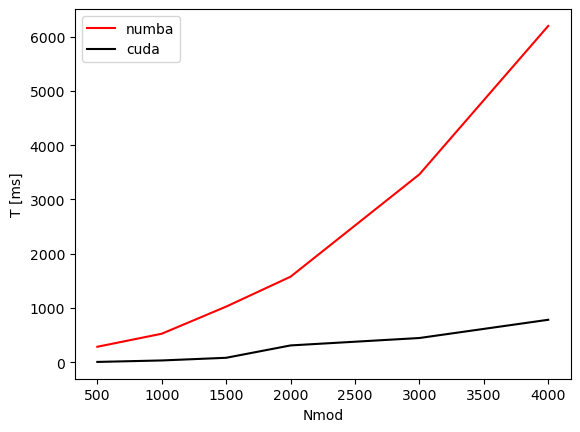

In [16]:
plt.figure()
plt.plot(nmodels, tsnumba, 'r', label='numba')
plt.plot(nmodels, tscuda, 'k', label='cuda')
plt.xlabel('Nmod')
plt.ylabel('T [ms]')
plt.legend();